In [9]:
# upgrade pip tooling first
# %pip install -q --upgrade pip setuptools wheel

# remove any conflicting wheels that may be half-installed
# %pip uninstall -y -q numpy scipy scikit-learn array-api-compat

# install a compatible trio for Python 3.12
# %pip install -q --no-cache-dir --force-reinstall \
#  "numpy==2.1.2" "scipy==1.14.1" "scikit-learn==1.5.2"


In [10]:
# import os, time
# print("Restarting runtime to finalize installs…")
# time.sleep(1)
# os._exit(0)


# Imports + versions

In [11]:
import os, re, unicodedata, inspect
import numpy as np
import pandas as pd

import numpy as _np, scipy as _scipy, sklearn as _sk
print("NumPy:", _np.__version__)
print("SciPy:", _scipy.__version__)
print("sklearn:", _sk.__version__)


NumPy: 2.0.2
SciPy: 1.16.3
sklearn: 1.6.1


# Load both CSVs (raw)

In [12]:
SENTIMENT_CSV = "combined_sentiment_data.csv"
EMOTIONS_CSV  = "combined_emotion.csv"


read_opts = dict(
    dtype=str,
    na_values=["", " ", "NA", "NaN", "nan", None],
    keep_default_na=True,
    on_bad_lines="skip",
    encoding_errors="replace"
)

df_sent_raw = pd.read_csv(SENTIMENT_CSV, **read_opts)
df_emot_raw = pd.read_csv(EMOTIONS_CSV, **read_opts)

def guess_cols(df):
    candidates_text  = {"text","tweet","content","sentence","comment","body","review"}
    candidates_label = {"label","sentiment","target","polarity","emotion"}
    text_col  = next((c for c in df.columns if c.lower() in candidates_text),  df.columns[0])
    label_col = next((c for c in df.columns if c.lower() in candidates_label), df.columns[-1])
    return text_col, label_col

sent_text_col, sent_label_col = guess_cols(df_sent_raw)
emot_text_col, emot_label_col = guess_cols(df_emot_raw)

print("Sentiment shape:", df_sent_raw.shape, "| guessed:", sent_text_col, "/", sent_label_col)
print("Emotion   shape:", df_emot_raw.shape, "| guessed:", emot_text_col, "/", emot_label_col)


Sentiment shape: (3309, 2) | guessed: sentence / sentiment
Emotion   shape: (20187, 2) | guessed: sentence / emotion


# Clean + encode (for both datasets)

In [13]:
from sklearn.preprocessing import LabelEncoder

def clean_and_encode(df_raw, text_col, label_col):
    df = df_raw.rename(columns={text_col: "text", label_col: "label"}).copy()
    df = df.dropna(subset=["text","label"])
    df["text"] = df["text"].astype(str).str.strip()
    df = df[df["text"].str.len() > 0]

    # dedupe to avoid leakage later
    df["_norm"] = (
        df["text"].str.lower()
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    df = df.drop_duplicates(subset=["_norm","label"]).drop(columns=["_norm"]).reset_index(drop=True)

    # label encode
    le = LabelEncoder()
    df["label_encoded"] = le.fit_transform(df["label"].astype(str))
    id2label = {i: lab for i, lab in enumerate(le.classes_)}
    label2id = {lab: i for i, lab in id2label.items()}
    return df, id2label, label2id, len(id2label)

df_sent, id2label_sent, label2id_sent, num_labels_sent = clean_and_encode(df_sent_raw, sent_text_col, sent_label_col)
df_emot, id2label_emot, label2id_emot, num_labels_emot = clean_and_encode(df_emot_raw, emot_text_col, emot_label_col)

print(f"[Sentiment] rows={len(df_sent)} classes={num_labels_sent}")
print(f"[Emotion]   rows={len(df_emot)} classes={num_labels_emot}")


[Sentiment] rows=3286 classes=2
[Emotion]   rows=20182 classes=6


# Build a combined multitask dataframe

In [14]:
import pandas as pd
import numpy as np

IGNORE_INDEX = -100  # tells CE loss to ignore missing labels

# Rename encoded columns to task-specific names
sent_df = df_sent[["text", "label_encoded"]].rename(columns={"label_encoded": "label_sent"})
emot_df = df_emot[["text", "label_encoded"]].rename(columns={"label_encoded": "label_emot"})

# Tag rows and add masked columns
sent_df["label_emot"] = IGNORE_INDEX
emot_df["label_sent"] = IGNORE_INDEX

# Union of both datasets (rows from each carry one valid label and one masked)
mtl_df = pd.concat([sent_df, emot_df], ignore_index=True)

# (Optional) Shuffle for mixing tasks
mtl_df = mtl_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Quick peek
print(mtl_df.head(3))
print("Counts:",
      "\n rows:", len(mtl_df),
      "\n sentiment-labeled:", (mtl_df["label_sent"] != IGNORE_INDEX).sum(),
      "\n emotion-labeled:  ", (mtl_df["label_emot"] != IGNORE_INDEX).sum())


                                                text  label_sent  label_emot
0  i just looove how youthful this song makes me ...        -100           2
1  i feel the is a very vital word to making your...        -100           2
2  i feel very sweet now linda clinda chung discl...        -100           3
Counts: 
 rows: 23468 
 sentiment-labeled: 3286 
 emotion-labeled:   20182


# Train/Val/Test split (stratify by “has which label”)

In [15]:
from sklearn.model_selection import train_test_split

RNG = 42
has_sent = (mtl_df["label_sent"] != IGNORE_INDEX).astype(int)
has_emot = (mtl_df["label_emot"] != IGNORE_INDEX).astype(int)

# We stratify by which task label exists to keep task mix similar across splits
train_df, hold_df = train_test_split(
    mtl_df, test_size=0.20, random_state=RNG,
    stratify=has_sent + 2*has_emot  # four combos (0/1 per task)
)
val_df, test_df = train_test_split(
    hold_df, test_size=0.50, random_state=RNG,
    stratify=(hold_df["label_sent"] != IGNORE_INDEX).astype(int) + 2*(hold_df["label_emot"] != IGNORE_INDEX).astype(int)
)

print("Sizes → train/val/test:", len(train_df), len(val_df), len(test_df))
print("Train task mix:",
      (train_df["label_sent"] != IGNORE_INDEX).sum(),
      (train_df["label_emot"] != IGNORE_INDEX).sum())


Sizes → train/val/test: 18774 2347 2347
Train task mix: 2629 16145


# Tokenizer + HF Datasets (labels per task)

In [16]:
from datasets import Dataset, Value
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tok(batch):
    enc = tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
    enc["labels_sent"] = batch["label_sent"]
    enc["labels_emot"] = batch["label_emot"]
    return enc

def to_ds(pdf):
    pdf = pdf.copy()
    pdf["label_sent"] = pdf["label_sent"].astype("int64")
    pdf["label_emot"] = pdf["label_emot"].astype("int64")
    ds = Dataset.from_pandas(pdf[["text","label_sent","label_emot"]], preserve_index=False)
    ds = ds.map(tok, batched=True, remove_columns=["text"])
    ds = ds.cast_column("labels_sent", Value("int64"))
    ds = ds.cast_column("labels_emot", Value("int64"))
    ds.set_format(type="torch",
                  columns=["input_ids","attention_mask","labels_sent","labels_emot"])
    return ds

train_ds = to_ds(train_df)
val_ds   = to_ds(val_df)
test_ds  = to_ds(test_df)

print("len(train_ds):", len(train_ds))
print("feature keys:", train_ds.features.keys())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/18774 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/18774 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/18774 [00:00<?, ? examples/s]

Map:   0%|          | 0/2347 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2347 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2347 [00:00<?, ? examples/s]

Map:   0%|          | 0/2347 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2347 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2347 [00:00<?, ? examples/s]

len(train_ds): 18774
feature keys: dict_keys(['label_sent', 'label_emot', 'input_ids', 'attention_mask', 'labels_sent', 'labels_emot'])


# Multi-head model (shared DistilBERT + 2 classifiers)

In [17]:
import torch
import torch.nn as nn
from transformers import AutoModel, PreTrainedModel, AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput

num_labels_s = num_labels_sent
num_labels_e = num_labels_emot
IGNORE_INDEX = -100

class MultiHeadDistilBert(nn.Module):
    def __init__(self, base_name, num_labels_sent, num_labels_emot):
        super().__init__()
        self.config = AutoConfig.from_pretrained(base_name)
        self.encoder = AutoModel.from_pretrained(base_name)
        hidden = self.config.dim  # DistilBERT hidden size
        self.dropout = nn.Dropout(0.2)
        self.classifier_sent = nn.Linear(hidden, num_labels_sent)
        self.classifier_emot = nn.Linear(hidden, num_labels_emot)
        self.loss_sent = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
        self.loss_emot = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

    def forward(self, input_ids=None, attention_mask=None,
                labels_sent=None, labels_emot=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # DistilBERT has no pooled output; use CLS token [0]
        cls = out.last_hidden_state[:, 0]  # [batch, hidden]
        cls = self.dropout(cls)

        logits_sent = self.classifier_sent(cls)   # [batch, C_s]
        logits_emot = self.classifier_emot(cls)   # [batch, C_e]

        loss = None
        losses = []
        if labels_sent is not None:
            losses.append(self.loss_sent(logits_sent, labels_sent))
        if labels_emot is not None:
            losses.append(self.loss_emot(logits_emot, labels_emot))
        if losses:
            # average when both present; single when only one present
            loss = sum(losses) / len(losses)

        # Trainer expects 'loss' and 'logits'. We'll also return task logits separately.
        logits_cat = torch.cat([logits_sent, logits_emot], dim=1)
        return {"loss": loss,
                "logits": logits_cat,
                "logits_sent": logits_sent,
                "logits_emot": logits_emot}

model = MultiHeadDistilBert(model_name, num_labels_s, num_labels_e)
sum_params = sum(p.numel() for p in model.parameters())
print("Params (M):", round(sum_params/1e6, 3))


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Params (M): 66.369


# Trainer (we’ll compute metrics ourselves later)

In [18]:
import inspect, transformers
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

print("Transformers:", transformers.__version__)
EVAL_ARG_NAME = "eval_strategy" if "eval_strategy" in inspect.signature(TrainingArguments.__init__).parameters else "evaluation_strategy"

training_kwargs = dict(
    output_dir="mtl_out",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.06,
    lr_scheduler_type="cosine",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    seed=42,
    fp16=True,                 # use mixed precision on GPU
    dataloader_num_workers=2,  # a bit more I/O parallelism

)
training_kwargs[EVAL_ARG_NAME] = "epoch"
training_args = TrainingArguments(**training_kwargs)

# No compute_metrics here—Trainer can’t natively handle two heads in its default pipeline.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

n_total = sum(p.numel() for p in model.parameters())
n_train = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Params total={n_total:,} | trainable={n_train:,}")
trainer.train()


Transformers: 4.57.1
Params total=66,369,032 | trainable=66,369,032


Epoch,Training Loss,Validation Loss
1,0.553700,nan
2,0.179200,nan
3,0.084500,nan


TrainOutput(global_step=7041, training_loss=0.27244098253200005, metrics={'train_runtime': 347.8526, 'train_samples_per_second': 215.885, 'train_steps_per_second': 26.988, 'total_flos': 0.0, 'train_loss': 0.27244098253200005, 'epoch': 3.0})

# Evaluate per task (VAL + TEST) with our own loop

In [19]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def eval_task(ds, task="sent"):
    loader = torch.utils.data.DataLoader(ds, batch_size=64)
    model.eval()
    preds, refs = [], []
    key = "labels_sent" if task == "sent" else "labels_emot"
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(model.classifier_sent.weight.device) if hasattr(v, "to") else v for k,v in batch.items()}
            out = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            logits = out["logits_sent"] if task == "sent" else out["logits_emot"]
            y = batch[key]
            # keep only rows where label != IGNORE_INDEX
            mask = (y != IGNORE_INDEX)
            if mask.sum() == 0:
                continue
            logits = logits[mask]
            y = y[mask]
            preds.extend(logits.argmax(dim=1).cpu().numpy().tolist())
            refs.extend(y.cpu().numpy().tolist())
    if len(refs) == 0:
        return {}
    acc = accuracy_score(refs, preds)
    avg = "binary" if (task=="sent" and num_labels_s==2) else "macro"
    pr = precision_score(refs, preds, average=avg, zero_division=0)
    rc = recall_score(refs, preds, average=avg, zero_division=0)
    f1 = f1_score(refs, preds, average=avg, zero_division=0)
    f1_micro = f1_score(refs, preds, average="micro", zero_division=0)
    return {"accuracy":acc, "precision":pr, "recall":rc, "f1":f1, "f1_micro":f1_micro}

print("VAL  — sentiment:", eval_task(val_ds, "sent"))
print("VAL  — emotion  :", eval_task(val_ds, "emot"))
print("TEST — sentiment:", eval_task(test_ds, "sent"))
print("TEST — emotion  :", eval_task(test_ds, "emot"))


VAL  — sentiment: {'accuracy': 0.9176829268292683, 'precision': 0.9127906976744186, 'recall': 0.9289940828402367, 'f1': 0.9208211143695014, 'f1_micro': 0.9176829268292683}
VAL  — emotion  : {'accuracy': 0.9281822684497276, 'precision': 0.8904392970232476, 'recall': 0.8907426026554669, 'f1': 0.8864314563480092, 'f1_micro': 0.9281822684497276}
TEST — sentiment: {'accuracy': 0.9088145896656535, 'precision': 0.9345238095238095, 'recall': 0.8920454545454546, 'f1': 0.9127906976744186, 'f1_micro': 0.9088145896656535}
TEST — emotion  : {'accuracy': 0.9331020812685827, 'precision': 0.9041786521099325, 'recall': 0.906093691961277, 'f1': 0.9043549350038078, 'f1_micro': 0.9331020812685827}


# Inference helper (single text → both predictions)

In [20]:
import torch
import numpy as np

def predict_both(texts, topk_emotion=3):
    if isinstance(texts, str):
        texts = [texts]
    enc = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
    enc = {k: v.to(next(model.parameters()).device) for k,v in enc.items()}
    model.eval()
    with torch.no_grad():
        out = model(**enc)
        ls, le = out["logits_sent"], out["logits_emot"]
        ps = torch.softmax(ls, dim=-1).cpu().numpy()
        pe = torch.softmax(le, dim=-1).cpu().numpy()

    # decode using task label maps
    id2s = id2label_sent
    id2e = id2label_emot

    results = []
    for i in range(len(texts)):
        # sentiment top-1
        s_idx = int(ps[i].argmax())
        s = {"label": id2s[s_idx], "score": float(ps[i][s_idx])}
        # emotion top-k
        top_idx = np.argsort(-pe[i])[:topk_emotion]
        e = [{"label": id2e[int(j)], "score": float(pe[i][j])} for j in top_idx]
        results.append({"text": texts[i], "sentiment": s, "emotion_topk": e})
    return results

# Example:
for r in predict_both(["I absolutely loved the movie!", "This is frustrating and makes me sad."]):
    print(r)


{'text': 'I absolutely loved the movie!', 'sentiment': {'label': 'positive', 'score': 0.9999434947967529}, 'emotion_topk': [{'label': 'love', 'score': 0.8381580114364624}, {'label': 'joy', 'score': 0.13979695737361908}, {'label': 'suprise', 'score': 0.018091682344675064}]}
{'text': 'This is frustrating and makes me sad.', 'sentiment': {'label': 'negative', 'score': 0.9999023675918579}, 'emotion_topk': [{'label': 'sad', 'score': 0.9386257529258728}, {'label': 'anger', 'score': 0.05647905915975571}, {'label': 'fear', 'score': 0.002545330673456192}]}


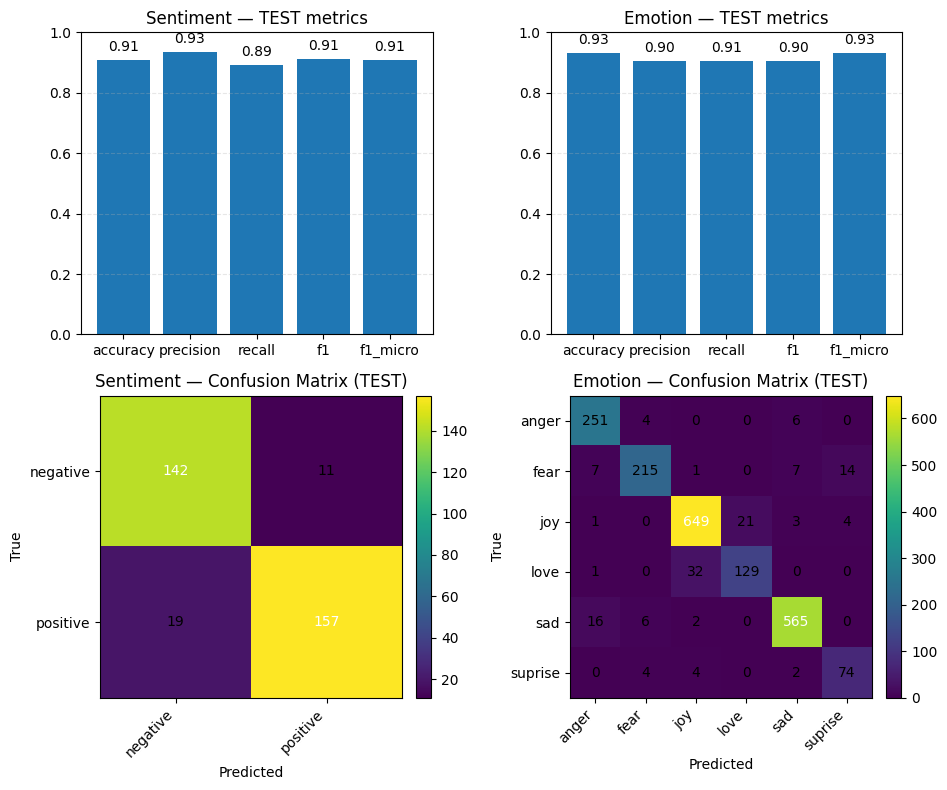

In [21]:
# Cell — Visualize multi-head TEST results (metrics + confusion matrices)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch

IGNORE_INDEX = -100  # must match what you used when building the multitask dataset

def _preds_and_refs(ds, which="sent"):
    """Return (y_true, y_pred) for a given head on a dataset, masking -100."""
    is_sent = (which == "sent")
    key = "labels_sent" if is_sent else "labels_emot"
    ys, ps = [], []
    loader = torch.utils.data.DataLoader(ds, batch_size=64)
    model.eval()
    with torch.no_grad():
        for batch in loader:
            device = next(model.parameters()).device
            input_ids = batch["input_ids"].to(device)
            attn      = batch["attention_mask"].to(device)
            labels    = batch[key]
            out = model(input_ids=input_ids, attention_mask=attn)
            logits = out["logits_sent"] if is_sent else out["logits_emot"]
            mask = (labels != IGNORE_INDEX)
            if mask.sum() == 0:
                continue
            y = labels[mask].numpy()
            p = logits[mask].argmax(dim=1).cpu().numpy()
            ys.append(y); ps.append(p)
    if not ys:
        return np.array([]), np.array([])
    return np.concatenate(ys), np.concatenate(ps)

# Collect predictions/labels on TEST
y_s_true, y_s_pred = _preds_and_refs(test_ds, "sent")
y_e_true, y_e_pred = _preds_and_refs(test_ds, "emot")

def _metrics(y_true, y_pred, avg):
    if y_true.size == 0:
        return dict(accuracy=np.nan, precision=np.nan, recall=np.nan, f1=np.nan, f1_micro=np.nan)
    return dict(
        accuracy = accuracy_score(y_true, y_pred),
        precision= precision_score(y_true, y_pred, average=avg, zero_division=0),
        recall   = recall_score(y_true, y_pred, average=avg, zero_division=0),
        f1       = f1_score(y_true, y_pred, average=avg, zero_division=0),
        f1_micro = f1_score(y_true, y_pred, average="micro", zero_division=0),
    )

avg_s = "binary" if (len(set(y_s_true.tolist())) == 2) else "macro"
avg_e = "macro"

m_s = _metrics(y_s_true, y_s_pred, avg_s)
m_e = _metrics(y_e_true, y_e_pred, avg_e)

# Build confusion matrices
def _cm(y_true, y_pred, labels):
    if y_true.size == 0:
        return None
    return confusion_matrix(y_true, y_pred, labels=range(len(labels)))

labels_sent = [id2label_sent[i] for i in range(len(id2label_sent))]
labels_emot = [id2label_emot[i] for i in range(len(id2label_emot))]

cm_s = _cm(y_s_true, y_s_pred, labels_sent)
cm_e = _cm(y_e_true, y_e_pred, labels_emot)

# --- Plot ---
fig = plt.figure(figsize=(14, 8))

# Bar charts (top row)
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))

def bar_metrics(ax, metrics_dict, title):
    keys = ["accuracy","precision","recall","f1","f1_micro"]
    vals = [metrics_dict[k] for k in keys]
    ax.bar(keys, vals)
    ax.set_ylim(0, 1.0)
    ax.set_title(title)
    ax.grid(True, axis="y", linestyle="--", alpha=0.3)
    for i, v in enumerate(vals):
        if np.isnan(v): continue
        ax.text(i, v + 0.02, f"{v:.2f}", ha="center", va="bottom")

bar_metrics(ax1, m_s, "Sentiment — TEST metrics")
bar_metrics(ax2, m_e, "Emotion — TEST metrics")

# Confusion matrices (bottom row spans columns)
ax3 = plt.subplot2grid((2, 3), (1, 0))
ax4 = plt.subplot2grid((2, 3), (1, 1))

def show_cm(ax, cm, class_names, title):
    if cm is None:
        ax.axis("off")
        ax.set_title(title + "\n(no labeled examples in TEST for this head)")
        return
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)
    thresh = cm.max() / 2 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel("True"); ax.set_xlabel("Predicted")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

show_cm(ax3, cm_s, labels_sent, "Sentiment — Confusion Matrix (TEST)")
show_cm(ax4, cm_e, labels_emot, "Emotion — Confusion Matrix (TEST)")

# Tight layout and show
plt.tight_layout()
plt.show()
